# A training example in Pytorch
## Introduction
### Task
In this notebook we will train a neural network to do a simple task. This will be a classification task : as explained in the first week of lectures, classification basically means to find a *decision boundary* over a space of real numbers. For representation purposes we will work with a 2D example : the decision boundary will be a cercle. More precisely, it will be the unity circle in the plan.
![](unitycircle.png)
### Sampling
We will generate points $(x_1,x_2)$ to classify, and their class $y$. The actual decision fonction is $y=1_{x_1^2+x_2^2<1}$.

To have a balanced dataset with about as many points in each class, we will sample uniformly over polar coordinates,  within the circle of center 0 and radius 2.

In [1]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
%matplotlib inline

In [27]:
def sample_points(n):
    # returns (X,Y), where X of shape (n,2) is the numpy array of points and Y is the (n) array of classes
    
    radius = np.random.uniform(low=0,high=2,size=n).reshape(-1,1) # uniform radius between 0 and 2
    angle = np.random.uniform(low=0,high=2*np.pi,size=n).reshape(-1,1) # uniform angle
    x1 = radius*np.cos(angle)
    x2=radius*np.sin(angle)
    y = (radius<1).astype(int).reshape(-1)
    x = np.concatenate([x1,x2],axis=1)
    return x,y

In [37]:
# Generate the data
trainx,trainy = sample_points(10000)
valx,valy = sample_points(500)
testx,testy = sample_points(500)

print(trainx.shape,trainy.shape)

(10000, 2) (10000,)


Our model will be a multi-layer perceptron with one hidden layer, and an output of size 2 since we have two classes. Since it is a binary classification task we could also use just one output and a zero threshold, but we will use two to illustrate the use of the pytorch Cross-Entropy loss (next week you will see how to use BinaryCrossEntropy for such a task).

As you know from the lectures, such a model cannot represent a circular boundary but could represent a polygonal boundary, whose number of sides is the number of neurons on the hidden layer. For example, with 6 hidden neurons the model could compute a hexagonal boundary that approximate the unity circle, such as :
![](hexagon.png)

Note that the optimal accuracy to expect from an hexagone approximating the unity circle is of about **xxxx**. Of course the trained model won't compute an actual hexagone, due to the activation that isn't a threshold, and the liberty of the final layer's weights (it does not have to be an AND). We can actually expect *better* accuracy than this.

In [38]:
def generate_single_hidden_MLP(n_hidden_neurons):
    return nn.Sequential(nn.Linear(2,n_hidden_neurons),nn.ReLU(),nn.Linear(n_hidden_neurons,2))
model1 = generate_single_hidden_MLP(6)

To train our model, we will need to feed it with tensors. Let's transform our generated numpy arrays :

In [39]:
trainx = torch.from_numpy(trainx).float()
valx = torch.from_numpy(valx).float()
testx = torch.from_numpy(testx).float()
trainy = torch.from_numpy(trainy)
valy = torch.from_numpy(valy)
testy = torch.from_numpy(testy)
print(trainx.type(),trainy.type())

torch.FloatTensor torch.LongTensor


Now we will define our training routine. There is the question of whether to perform our traing on CPU or GPU. The best thing to do is to use a flag variable that you will set, when you actually do the training.

In [40]:
def training_routine(net,dataset,n_iters,gpu):
    # organize the data
    train_data,train_labels,val_data,val_labels = dataset
    
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(net.parameters(),lr=0.01)
    
    # use the flag
    if gpu:
        train_data,train_labels = train_data.cuda(),train_labels.cuda()
        val_data,val_labels = val_data.cuda(),val_labels.cuda()
        net = net.cuda() # the network parameters also need to be on the gpu !
        print("Using GPU")
    else:
        print("Using CPU")
    for i in range(n_iters):
        # forward pass
        train_output = net(train_data)
        train_loss = criterion(train_output,train_labels)
        # backward pass and optimization
        train_loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        
        # Once every 100 iterations, print statistics
        if i%100==0:
            print("At iteration",i)
            # compute the accuracy of the prediction
            train_prediction = train_output.cpu().detach().argmax(dim=1)
            train_accuracy = (train_prediction.numpy()==train_labels.numpy()).mean() 
            # Now for the validation set
            val_output = net(val_data)
            val_loss = criterion(val_output,val_labels)
            # compute the accuracy of the prediction
            val_prediction = val_output.cpu().detach().argmax(dim=1)
            val_accuracy = (val_prediction.numpy()==val_labels.numpy()).mean() 
            print("Training loss :",train_loss.cpu().detach().numpy())
            print("Training accuracy :",train_accuracy)
            print("Validation loss :",val_loss.cpu().detach().numpy())
            print("Validation accuracy :",val_accuracy)
    
    net = net.cpu()

In [41]:
dataset = trainx,trainy,valx,valy

In [42]:
gpu = False
gpu = gpu and torch.cuda.is_available() # to know if you actually can use the GPU

training_routine(model1,dataset,10000,gpu)

Using CPU
At iteration 0
Training loss : 0.71831536
Training accuracy : 0.3945
Validation loss : 0.7087014
Validation accuracy : 0.446
At iteration 100
Training loss : 0.700447
Training accuracy : 0.441
Validation loss : 0.6938999
Validation accuracy : 0.494
At iteration 200
Training loss : 0.68652636
Training accuracy : 0.4929
Validation loss : 0.682234
Validation accuracy : 0.536
At iteration 300
Training loss : 0.67489254
Training accuracy : 0.5013
Validation loss : 0.6724105
Validation accuracy : 0.54
At iteration 400
Training loss : 0.6638922
Training accuracy : 0.7233
Validation loss : 0.66276276
Validation accuracy : 0.714
At iteration 500
Training loss : 0.65255404
Training accuracy : 0.7533
Validation loss : 0.65231085
Validation accuracy : 0.76
At iteration 600
Training loss : 0.6402846
Training accuracy : 0.7672
Validation loss : 0.64061856
Validation accuracy : 0.776
At iteration 700
Training loss : 0.62680674
Training accuracy : 0.7758
Validation loss : 0.62757605
Validati

At iteration 6500
Training loss : 0.1596637
Training accuracy : 0.9707
Validation loss : 0.17935649
Validation accuracy : 0.954
At iteration 6600
Training loss : 0.15789872
Training accuracy : 0.9707
Validation loss : 0.17759384
Validation accuracy : 0.954
At iteration 6700
Training loss : 0.15619776
Training accuracy : 0.9708
Validation loss : 0.17588332
Validation accuracy : 0.952
At iteration 6800
Training loss : 0.15455613
Training accuracy : 0.971
Validation loss : 0.1742313
Validation accuracy : 0.952
At iteration 6900
Training loss : 0.15297212
Training accuracy : 0.9708
Validation loss : 0.1726348
Validation accuracy : 0.952
At iteration 7000
Training loss : 0.15144639
Training accuracy : 0.9711
Validation loss : 0.17108968
Validation accuracy : 0.952
At iteration 7100
Training loss : 0.14997055
Training accuracy : 0.9714
Validation loss : 0.16959451
Validation accuracy : 0.952
At iteration 7200
Training loss : 0.14854035
Training accuracy : 0.9713
Validation loss : 0.16814576


In [43]:
# Let's try with 3 hidden neurons.
model2 = generate_single_hidden_MLP(3) 
training_routine(model2,dataset,10000,gpu)

Using CPU
At iteration 0
Training loss : 0.8029221
Training accuracy : 0.5013
Validation loss : 0.76337916
Validation accuracy : 0.54
At iteration 100
Training loss : 0.71322155
Training accuracy : 0.5013
Validation loss : 0.6946508
Validation accuracy : 0.54
At iteration 200
Training loss : 0.6911888
Training accuracy : 0.5013
Validation loss : 0.68136626
Validation accuracy : 0.54
At iteration 300
Training loss : 0.6815174
Training accuracy : 0.4956
Validation loss : 0.6758092
Validation accuracy : 0.536
At iteration 400
Training loss : 0.6739168
Training accuracy : 0.4632
Validation loss : 0.67049855
Validation accuracy : 0.52
At iteration 500
Training loss : 0.66649586
Training accuracy : 0.6492
Validation loss : 0.6646509
Validation accuracy : 0.664
At iteration 600
Training loss : 0.6588136
Training accuracy : 0.7192
Validation loss : 0.65822923
Validation accuracy : 0.726
At iteration 700
Training loss : 0.65065104
Training accuracy : 0.7185
Validation loss : 0.6512389
Validatio

At iteration 6600
Training loss : 0.18111315
Training accuracy : 0.9547
Validation loss : 0.21230017
Validation accuracy : 0.938
At iteration 6700
Training loss : 0.17903371
Training accuracy : 0.9547
Validation loss : 0.21015002
Validation accuracy : 0.938
At iteration 6800
Training loss : 0.17701696
Training accuracy : 0.9548
Validation loss : 0.20805731
Validation accuracy : 0.94
At iteration 6900
Training loss : 0.17506331
Training accuracy : 0.9552
Validation loss : 0.2060337
Validation accuracy : 0.942
At iteration 7000
Training loss : 0.17317495
Training accuracy : 0.955
Validation loss : 0.20408668
Validation accuracy : 0.942
At iteration 7100
Training loss : 0.17134611
Training accuracy : 0.9554
Validation loss : 0.20219502
Validation accuracy : 0.942
At iteration 7200
Training loss : 0.16958489
Training accuracy : 0.9554
Validation loss : 0.20037013
Validation accuracy : 0.942
At iteration 7300
Training loss : 0.16787772
Training accuracy : 0.9554
Validation loss : 0.19860685

In [44]:
out = model2(testx).argmax(dim=1).detach().numpy()
green = testx.numpy()[np.where(out==1)]
red = testx.numpy()[np.where(out==0)]
print(green.shape,red.shape)

(240, 2) (260, 2)


In [46]:
def print_model(model,datapoints):
    out = model(datapoints).argmax(dim=1).detach().numpy()
    green = datapoints.numpy()[np.where(out==1)]
    red = datapoints.numpy()[np.where(out==0)]

    circle1 = plt.Circle((0, 0), 1, color='y')
    circle2 = plt.Circle((0, 0), 1, color='b',fill=False)

    fig, ax = plt.subplots() # note we must use plt.subplots, not plt.subplot
    # (or if you have an existing figure)
    # fig = plt.gcf()
    # ax = fig.gca()
    plt.xlim((-2,2))
    plt.ylim((-2,2))

    pos_values = plt.scatter(x=green[:,0],y=green[:,1], color='g',)
    neg_values = plt.scatter(x=red[:,0],y=red[:,1], color='r',)

    ax.add_artist(circle1)
    ax.add_artist(circle2)
    ax.add_artist(pos_values)
    ax.add_artist(neg_values)

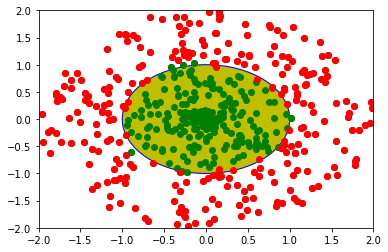

In [48]:
print_model(model1,testx)

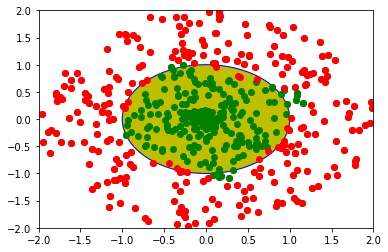

In [49]:
print_model(model2,testx)

In [50]:
model3 = generate_single_hidden_MLP(2) 
training_routine(model3,dataset,10000,gpu)

Using CPU
At iteration 0
Training loss : 0.74489075
Training accuracy : 0.4987
Validation loss : 0.768003
Validation accuracy : 0.46
At iteration 100
Training loss : 0.70779586
Training accuracy : 0.4987
Validation loss : 0.72009563
Validation accuracy : 0.46
At iteration 200
Training loss : 0.69708997
Training accuracy : 0.4987
Validation loss : 0.703615
Validation accuracy : 0.46
At iteration 300
Training loss : 0.6937979
Training accuracy : 0.5245
Validation loss : 0.6972375
Validation accuracy : 0.478
At iteration 400
Training loss : 0.6925687
Training accuracy : 0.6582
Validation loss : 0.69438845
Validation accuracy : 0.618
At iteration 500
Training loss : 0.6918613
Training accuracy : 0.6519
Validation loss : 0.69285
Validation accuracy : 0.63
At iteration 600
Training loss : 0.69118875
Training accuracy : 0.6199
Validation loss : 0.6917865
Validation accuracy : 0.596
At iteration 700
Training loss : 0.6903696
Training accuracy : 0.5877
Validation loss : 0.6908153
Validation acc

At iteration 6600
Training loss : 0.55443364
Training accuracy : 0.7335
Validation loss : 0.571533
Validation accuracy : 0.698
At iteration 6700
Training loss : 0.5504198
Training accuracy : 0.7461
Validation loss : 0.5679279
Validation accuracy : 0.718
At iteration 6800
Training loss : 0.54638493
Training accuracy : 0.7572
Validation loss : 0.56429744
Validation accuracy : 0.736
At iteration 6900
Training loss : 0.5423946
Training accuracy : 0.7658
Validation loss : 0.5607052
Validation accuracy : 0.744
At iteration 7000
Training loss : 0.53847307
Training accuracy : 0.771
Validation loss : 0.5571515
Validation accuracy : 0.748
At iteration 7100
Training loss : 0.53464425
Training accuracy : 0.7742
Validation loss : 0.5536982
Validation accuracy : 0.744
At iteration 7200
Training loss : 0.530913
Training accuracy : 0.778
Validation loss : 0.55032355
Validation accuracy : 0.748
At iteration 7300
Training loss : 0.5272961
Training accuracy : 0.7797
Validation loss : 0.5470012
Validation

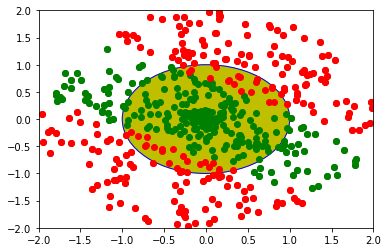

In [51]:
print_model(model3,testx)